# Analisis Sentimen Ulasan Pariwisata Bali

## 1. Import Library

In [13]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import joblib
import pickle
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense


## 2. Data Loading

In [3]:
data_folder = "./data"
csv_files = [f for f in os.listdir(data_folder) if f.endswith("_reviews.csv")]
df_list = []

for file in csv_files:
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)
    destination_name = file.replace("_reviews.csv", "").replace("_", " ").title()
    df["destination"] = destination_name

    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)
combined_df.to_csv(os.path.join(data_folder, "all_reviews_combined.csv"), index=False)
df = combined_df
print(combined_df.head())

        user  rating                   review                date  year  \
0   Daniel C       1             Don’t bother   May 2025 • Family  2025   
1   Daniel F       5  Bird feeding at the zoo   May 2025 • Family  2025   
2   Amelia h       5                  Must go  May 2025 • Friends  2025   
3  Britney D       5       Mud bath elephants   May 2025 • Family  2025   
4  Moumita G       5      Lifetime experience   May 2025 • Family  2025   

  destination  
0    Bali Zoo  
1    Bali Zoo  
2    Bali Zoo  
3    Bali Zoo  
4    Bali Zoo  


## 3. Data Cleaning

In [4]:
def clean_text(text):
    text = str(text).lower()                           
    text = re.sub(r'http\S+', '', text)                
    text = re.sub(r'[^a-z\s]', '', text)               
    text = re.sub(r'\s+', ' ', text).strip()           
    return text

df["clean_review"] = df["review"].apply(clean_text)
print(df["clean_review"].head())


0                dont bother
1    bird feeding at the zoo
2                    must go
3         mud bath elephants
4        lifetime experience
Name: clean_review, dtype: object


## 4. Pelabelan Sentimen

In [5]:
def label_sentiment(rating):
    if rating <= 2:
        return 0  # Negatif
    elif rating == 3:
        return 1  # Netral
    else:
        return 2  # Positif

df["sentiment"] = df["rating"].apply(label_sentiment)
print(df["sentiment"].value_counts())

2    1156
0      50
1      36
Name: sentiment, dtype: int64


## 5. Data Splitting

In [6]:

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_review"])
sequences = tokenizer.texts_to_sequences(df["clean_review"])
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

X_train, X_test, y_train, y_test = train_test_split(
    padded, df["sentiment"], test_size=0.2, random_state=42
)

## 6. Modelling

In [7]:

model = Sequential([
    Embedding(input_dim=10000, output_dim=16, input_length=100),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')  
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## 7. Evaluasi Model

In [8]:

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10
32/32 [==============================] - 1s 14ms/step - loss: 1.0417 - accuracy: 0.8369 - val_loss: 0.9754 - val_accuracy: 0.9357
Epoch 2/10
32/32 [==============================] - 0s 6ms/step - loss: 0.9040 - accuracy: 0.9295 - val_loss: 0.8090 - val_accuracy: 0.9357
Epoch 3/10
32/32 [==============================] - 0s 6ms/step - loss: 0.7125 - accuracy: 0.9295 - val_loss: 0.5886 - val_accuracy: 0.9357
Epoch 4/10
32/32 [==============================] - 0s 6ms/step - loss: 0.4885 - accuracy: 0.9295 - val_loss: 0.3774 - val_accuracy: 0.9357
Epoch 5/10
32/32 [==============================] - 0s 10ms/step - loss: 0.3464 - accuracy: 0.9295 - val_loss: 0.2993 - val_accuracy: 0.9357
Epoch 6/10
32/32 [==============================] - 0s 13ms/step - loss: 0.3082 - accuracy: 0.9295 - val_loss: 0.2846 - val_accuracy: 0.9357
Epoch 7/10
32/32 [==============================] - 0s 7ms/step - loss: 0.3029 - accuracy: 0.9295 - val_loss: 0.2814 - val_accuracy: 0.9357
Epoch 8/10
32/32 

## 8. Visualisasi Data

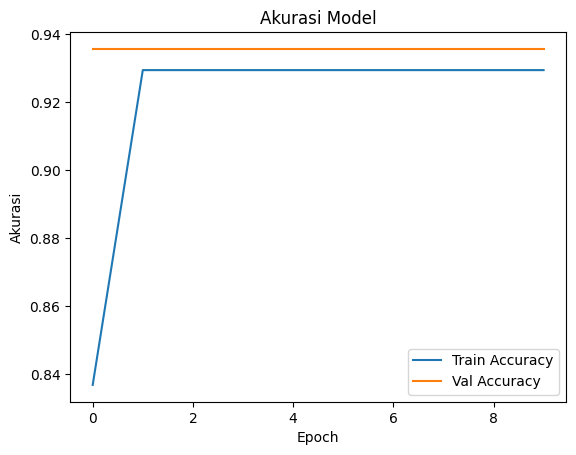

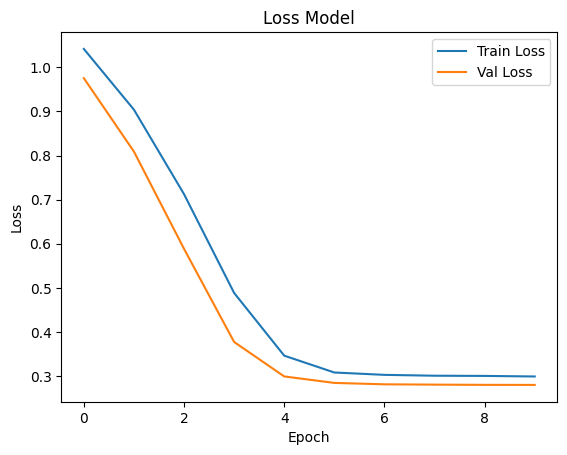

In [9]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

8/8 [==============================] - 0s 2ms/step


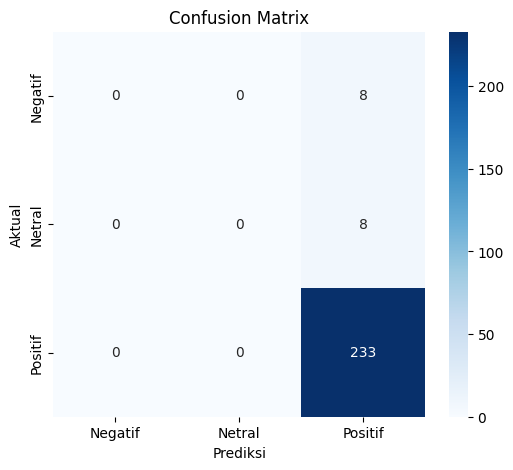

              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00         8
      Netral       0.00      0.00      0.00         8
     Positif       0.94      1.00      0.97       233

    accuracy                           0.94       249
   macro avg       0.31      0.33      0.32       249
weighted avg       0.88      0.94      0.90       249



c:\Users\Asus\.conda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Asus\.conda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Asus\.conda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)

unique_labels = np.unique(np.concatenate([y_test, y_pred]))
label_names_map = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}
label_names = [label_names_map[label] for label in unique_labels]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred, target_names=label_names))

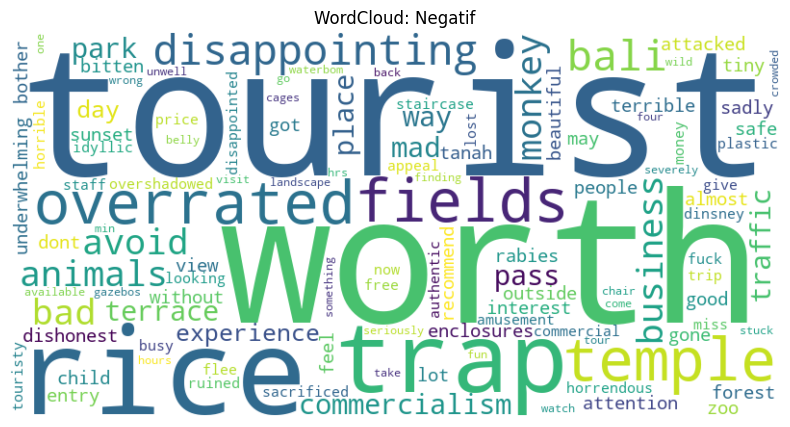

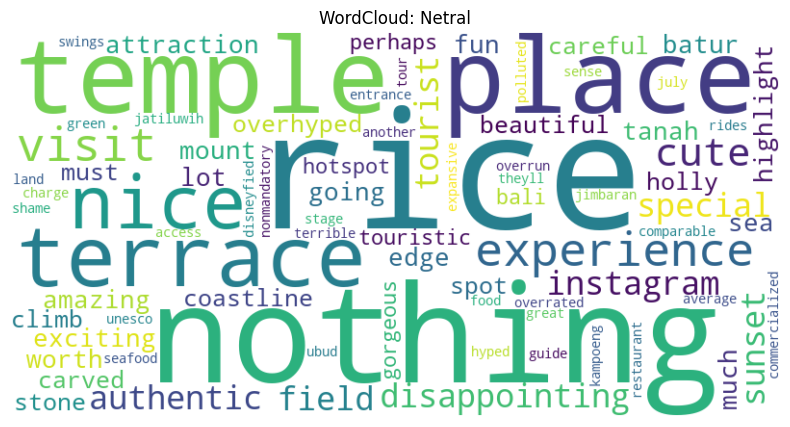

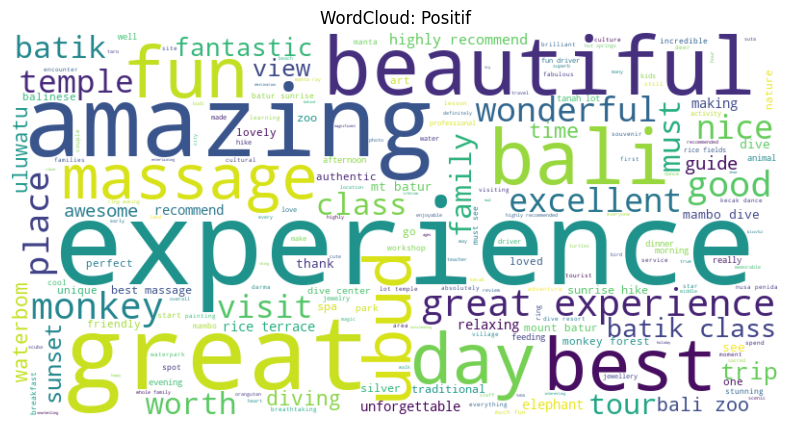

In [11]:
for label, name in zip([0, 1, 2], ['Negatif', 'Netral', 'Positif']):
    text = " ".join(df[df["sentiment"] == label]["clean_review"])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud: {name}")
    plt.show()

## 9. Konversi Model

In [16]:
df.to_csv("final_labeled_reviews.csv", index=False)
print("Data berhasil disimpan ke '../final_labeled_reviews.csv'")
joblib.dump(model, '../sentiment_model.pkl')
model.save("../sentiment_model.h5")
# Simpan tokenizer ke file
with open("../tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

Data berhasil disimpan ke '../final_labeled_reviews.csv'
